In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melting-point/sample_submission.csv
/kaggle/input/melting-point/train.csv
/kaggle/input/melting-point/test.csv


In [2]:
pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 43.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import Bibliothèque
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
from rdkit.Chem import AllChem, DataStructs

In [4]:
#Importation des fichiers csv 
folder_path = "/kaggle/input/melting-point"
train_csv_path = '/kaggle/input/melting-point/train.csv'
train_csv = pd.read_csv(train_csv_path)
print(train_csv.head())

test_csv_path = '/kaggle/input/melting-point/test.csv'
test_csv = pd.read_csv(test_csv_path)
#print(test_csv.head())

     id                       SMILES      Tm  Group 1  Group 2  Group 3  \
0  2175        FC1=C(F)C(F)(F)C1(F)F  213.15        0        0        0   
1  1222  c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15        0        0        0   
2  2994          CCN1C(C)=Nc2ccccc12  324.15        2        1        0   
3  1704                   CC#CC(=O)O  351.15        1        0        0   
4  2526                    CCCCC(S)C  126.15        2        3        0   

   Group 4  Group 5  Group 6  Group 7  ...  Group 415  Group 416  Group 417  \
0        0        0        0        0  ...          0          0          0   
1        0        0        0        0  ...          0          0          0   
2        0        0        0        0  ...          0          0          0   
3        0        0        0        0  ...          0          0          0   
4        0        0        0        0  ...          0          0          0   

   Group 418  Group 419  Group 420  Group 421  Group 422  Group 423  Group

In [29]:
#Chargement du Dataset complet
#Full dataset loading
train_data_set = train_csv
X_train_data_set = train_data_set
y = train_data_set['Tm']
list_columns = train_data_set.columns.tolist()
feature_names = list_columns[3:]

# print the list of columns in the dataset to find the name of the prediction target
#train_data_set.describe()

test_data_set = test_csv

In [30]:
#Retraitement des données sous la forme de 0 et 1 - Train
X_df = pd.DataFrame(train_data_set[feature_names])

#Créer les colonnes binaires
#binary_feats = {f"has_{col}": (X_df[col] > 0).astype(int) for col in feature_names}

#Ratios 
ratio_feats = {f"{col}_ratio": X_df[col] / (X_df[feature_names].sum(axis=1) + 1e-6) for col in feature_names}

#Totaux globaux
extra_feats = {
    "total_groups": X_df[feature_names].sum(axis=1),
    "nb_groups_non_zero": (X_df[feature_names] > 0).sum(axis=1),
}

# 5. Fusionner toutes les nouvelles colonnes d’un coup
#X_df = pd.concat([X_df, pd.DataFrame({**binary_feats, **ratio_feats, **extra_feats})], axis=1)
X_df = pd.concat([X_df, pd.DataFrame({**ratio_feats, **extra_feats})], axis=1)
X_train_data_set = pd.concat([X_train_data_set, pd.DataFrame({**ratio_feats, **extra_feats})], axis=1)
print("Shape après feature engineering:", X_df.shape)
print("Shape X_train_data_set après feature engineering:", X_train_data_set.shape)

Shape après feature engineering: (2662, 850)
Shape X_train_data_set après feature engineering: (2662, 853)


In [31]:
#Traitement des SMILES
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem

X_smiles = pd.DataFrame(train_data_set["SMILES"])

def compute_chem_features(df, smiles_col="smiles", add_fingerprint=True, fp_nbits=2048):
    """
    Prend un DataFrame avec une colonne de SMILES et renvoie un DataFrame de descripteurs chimiques.
    - df : DataFrame d'entrée (ne modifie pas df).
    - smiles_col : nom de la colonne SMILES.
    - add_fingerprint : bool, calcule fingerprint Morgan (binaire) si True.
    - fp_nbits : taille du vecteur fingerprint.
    """
    records = []
    invalid_idx = []
    
    # SMARTS motifs utiles (exemples)
    smarts = {
        "has_OH": "[OX2H]",              # alcool phénol etc. (H-bond donors)
        "has_carbonyl": "[CX3]=O",      # carbonyle
        "has_nitro": "[NX3](=O)=O",     # nitro
        "has_amine": "[NX3;!$(N-*=O)]", # amine primaire/secondaire/tertiaire (élimine nitro)
        "has_ester": "[$([CX3](=O)O)]",  # ester
        "has_thiol": "[SX2H]",           # thiol
    }
    smarts_compiled = {k: Chem.MolFromSmarts(v) for k, v in smarts.items()}
    
    for idx, smi in df[smiles_col].items():
        mol = None
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                # try sanitize false then sanitize
                mol = Chem.MolFromSmiles(smi, sanitize=False)
                if mol is not None:
                    Chem.SanitizeMol(mol)
        except Exception as e:
            mol = None
        
        if mol is None:
            invalid_idx.append(idx)
            # fill NaNs for invalid
            records.append({"index": idx, "valid_smiles": False})
            continue
        
        r = {"index": idx, "valid_smiles": True}
        
        # Atom counts (heavy atoms, heteroatoms, and halogens)
        atom_counts = {}
        for atom in mol.GetAtoms():
            sym = atom.GetSymbol()
            atom_counts[sym] = atom_counts.get(sym, 0) + 1
        # common atoms
        for at in ["C","H","O","N","F","Cl","Br","I","S","P"]:
            r[f"atom_count_{at}"] = atom_counts.get(at, 0)
        r["heavy_atom_count"] = rdMolDescriptors.CalcNumHeavyAtoms(mol)
        
        # Basic descriptors
        r["MolWt"] = Descriptors.ExactMolWt(mol)           # masse exacte
        r["MolLogP"] = Descriptors.MolLogP(mol)            # octanol-water partition
        r["MolMR"] = Descriptors.MolMR(mol)                # molar refractivity (approx)
        r["TPSA"] = rdMolDescriptors.CalcTPSA(mol)         # topological polar surface area
        r["NumHDonors"] = rdMolDescriptors.CalcNumHBD(mol)
        r["NumHAcceptors"] = rdMolDescriptors.CalcNumHBA(mol)
        r["NumRotatableBonds"] = rdMolDescriptors.CalcNumRotatableBonds(mol)
        r["NumRings"] = rdMolDescriptors.CalcNumRings(mol)
        r["NumAromaticRings"] = rdMolDescriptors.CalcNumAromaticRings(mol)
        r["FractionCSP3"] = Descriptors.FractionCSP3(mol)
        r["NumValenceElectrons"] = sum([a.GetTotalValence() for a in mol.GetAtoms()])
        r["FormalCharge"] = Chem.GetFormalCharge(mol)
        
        r["RingCount"] = Descriptors.RingCount(mol)
        r["HeavyAtomCount"] = Descriptors.HeavyAtomCount(mol)
        r["NumAliphaticRings"] = rdMolDescriptors.CalcNumAliphaticRings(mol)
        r["NumSaturatedRings"] = rdMolDescriptors.CalcNumSaturatedRings(mol)
        r["NumAliphaticCarbocycles"] = rdMolDescriptors.CalcNumAliphaticCarbocycles(mol)
        r["NumAromaticCarbocycles"] = rdMolDescriptors.CalcNumAromaticCarbocycles(mol)
        r["NumSaturatedCarbocycles"] = rdMolDescriptors.CalcNumSaturatedCarbocycles(mol)

        #Ajout de ratios supplémentaires
        r["PMolWtTPSA"] = r["MolWt"] * r["TPSA"]
        r["PMolLogPNumHDonors"] = r["MolLogP"] * r["NumHDonors"]
        r["PhbondMolWt"] = r["MolWt"]
        r["PNumAromRings"] = r["NumAromaticRings"] / (r["NumRings"]+1)
        
        # ring/aromaticity / complexity
        r["BertzCT"] = Descriptors.BertzCT(mol)             # complexité topologique
        # optionally: r["BalabanJ"] = Descriptors.J(mol)
        
        # SMARTS motif counts/presence
        for name, patt in smarts_compiled.items():
            try:
                matches = mol.GetSubstructMatches(patt)
                r[f"{name}_count"] = len(matches)
                r[f"{name}_present"] = int(len(matches) > 0)
            except Exception:
                r[f"{name}_count"] = 0
                r[f"{name}_present"] = 0
        
        # hydrogen bonding index (simple)
        r["hbond_index"] = r["NumHDonors"] * r["NumHAcceptors"]
        r["PhbondMolWt"] = r["hbond_index"] * r["MolWt"]
        # aromatic proportion
        r["aromatic_atom_fraction"] = sum(1 for a in mol.GetAtoms() if a.GetIsAromatic()) / max(1, mol.GetNumAtoms())
        
        # Morgan fingerprint (ECFP) as bit vector (optional)
        if add_fingerprint:
            try:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=fp_nbits)
                arr = np.zeros((1,), dtype=np.int8)
                # convert to numpy array
                onbits = list(fp.GetOnBits())
                # We'll create sparse representation: store as list of 0/1 ints in columns fp_0..fp_nbits-1
                for i in range(fp_nbits):
                    r[f"fp_{i}"] = 1 if i in onbits else 0
            except Exception:
                # fallback: no fp
                for i in range(fp_nbits):
                    r[f"fp_{i}"] = 0
        
        records.append(r)
    
    feats = pd.DataFrame(records).set_index("index")
    # Convert types and fill NaN for invalid SMILES
    feats = feats.sort_index()
    feats = feats.fillna(np.nan)
    
    # Optionally drop fp columns if too heavy
    return feats, invalid_idx

# Utilisation :
feats_df, invalids = compute_chem_features(X_smiles, smiles_col="SMILES", add_fingerprint=False)
print("Invalid SMILES indices:", invalids)
X_df = pd.concat([X_df, pd.DataFrame({**feats_df})], axis=1)
print("Shape après feature engineering chimique:", X_df.shape)
#print(X_df.head())
X_train_data_set = pd.concat([X_train_data_set, pd.DataFrame({**feats_df})], axis=1)
print("Shape après feature engineering chimique:", X_train_data_set.shape)

Invalid SMILES indices: []
Shape après feature engineering chimique: (2662, 900)
Shape après feature engineering chimique: (2662, 903)


In [33]:
#Génération des Morgan Fingerprints

# Configuration
smiles_col="SMILES"   # nom de la colonne contenant les SMILES
n_bits = 512            # taille du vecteur (128, 256, 512 — 256 est un bon compromis)
radius = 2             # rayon (2 = bon point de départ)

def morgan_fingerprint(smi, n_bits=256, radius=2):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return np.zeros(n_bits, dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# --- Application à ton dataset ---
print("🧬 Calcul des empreintes Morgan...")
fps = np.array([morgan_fingerprint(smi, n_bits, radius) for smi in tqdm(X_smiles[smiles_col])])

# --- Conversion en DataFrame ---
fp_cols = [f"morgan_{i}" for i in range(n_bits)]
df_fps = pd.DataFrame(fps, columns=fp_cols)

# --- Fusion avec ton DataFrame existant ---
X_df = pd.concat([X_df.reset_index(drop=True), df_fps], axis=1)

print(f"✅ Ajouté {n_bits} nouvelles colonnes de features Morgan.")
print(f"Nouvelle taille du DataFrame : {X_df.shape}")

X_train_data_set = pd.concat([X_train_data_set.reset_index(drop=True), df_fps], axis=1)
print(f"Nouvelle taille du DataFrame : {X_train_data_set.shape}")

🧬 Calcul des empreintes Morgan...


100%|██████████| 2662/2662 [00:00<00:00, 6532.97it/s]

✅ Ajouté 512 nouvelles colonnes de features Morgan.
Nouvelle taille du DataFrame : (2662, 1924)
Nouvelle taille du DataFrame : (2662, 1927)


In [35]:
#Retraitement du fichier Test
X_test_df = pd.DataFrame(test_data_set[feature_names])
X_test_smiles = pd.DataFrame(test_data_set["SMILES"])
#Créer les colonnes binaires
#binary_feats_test = {f"has_{col}": (X_test_df[col] > 0).astype(int) for col in feature_names}
ratio_feats_test = {f"{col}_ratio": X_test_df[col] / (X_test_df[feature_names].sum(axis=1) + 1e-6) for col in feature_names}
extra_feats_test = {
    "total_groups": X_test_df[feature_names].sum(axis=1),
    "nb_groups_non_zero": (X_test_df[feature_names] > 0).sum(axis=1),
}
X_test_df = pd.concat([X_test_df, pd.DataFrame({**ratio_feats_test, **extra_feats_test})], axis=1)
print("Shape après feature engineering:", X_test_df.shape)
feats_df, invalids = compute_chem_features(X_test_smiles, smiles_col="SMILES", add_fingerprint=False)
X_test_df = pd.concat([X_test_df, pd.DataFrame({**feats_df})], axis=1)
print("Shape après feature engineering chimique:", X_test_df.shape)

#Génération des Morgan Fingerprints
# --- Application à ton dataset ---
print("🧬 Calcul des empreintes Morgan...")
fps = np.array([morgan_fingerprint(smi, n_bits, radius) for smi in tqdm(X_test_smiles[smiles_col])])
# --- Conversion en DataFrame ---
fp_cols = [f"morgan_{i}" for i in range(n_bits)]
df_fps = pd.DataFrame(fps, columns=fp_cols)
# --- Fusion avec ton DataFrame existant ---
X_test_df = pd.concat([X_test_df.reset_index(drop=True), df_fps], axis=1)
print(f"✅ Ajouté {n_bits} nouvelles colonnes de features Morgan.")
print(f"Nouvelle taille du DataFrame : {X_test_df.shape}")


Shape après feature engineering: (666, 850)
Shape après feature engineering chimique: (666, 900)
🧬 Calcul des empreintes Morgan...


100%|██████████| 666/666 [00:00<00:00, 7505.18it/s]

✅ Ajouté 512 nouvelles colonnes de features Morgan.
Nouvelle taille du DataFrame : (666, 1412)


In [36]:
X = X_df
print(X.head())
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Split Train / Valid
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.2, random_state=42 )


   Group 1  Group 2  Group 3  Group 4  Group 5  Group 6  Group 7  Group 8  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        2        1        0        0        0        0        0        0   
3        1        0        0        0        0        0        0        0   
4        2        3        0        0        0        0        0        0   

   Group 9  Group 10  ...  morgan_502  morgan_503  morgan_504  morgan_505  \
0        0         0  ...           0           0           0           0   
1        0         0  ...           0           0           0           0   
2        0         0  ...           0           0           0           0   
3        0         0  ...           0           0           0           0   
4        0         0  ...           0           0           0           0   

   morgan_506  morgan_507  morgan_508  morgan_509  morgan_510  morgan_511 

**Import et Selection du modèle**

In [37]:
#from sklearn.model_selection import KFold, cross_val_score
#from sklearn.metrics import mean_absolute_error, make_scorer
#from sklearn.ensemble import StackingRegressor
#from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
import time
import itertools
#from lightgbm import LGBMRegressor
#from xgboost import XGBRegressor

In [13]:
#final_model = CatBoostRegressor(
#    iterations=1200,
#    learning_rate=0.09586251212066181,
#    depth=10,
#    loss_function = "MAE",
#    l2_leaf_reg=3,
#    bagging_temperature=2.031454661334689,
#    random_state=42,
#    verbose=100
#)
#final_model.fit(X, y)

In [38]:
X = X_df

print(X['valid smiles'])

KeyError: 'valid smiles'

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

#X = X_train_data_set.drop(columns=["ID", "SMILES", "Tm"], errors="ignore")
#y = df_enriched[target].values
X = X_df
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y))

for train_idx, val_idx in kf.split(X):
    model = CatBoostRegressor(
        iterations=1500,
        learning_rate=0.09586251212066181,
        depth=10,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False
    )
    model.fit(X.iloc[train_idx], y[train_idx])
    oof_preds[val_idx] = model.predict(X.iloc[val_idx])

errors = np.abs(oof_preds - y)
df_errors = X.copy()
df_errors["prediction"] = oof_preds
df_errors["error"] = errors

print("MAE global:", errors.mean())
df_errors.head()
X_train_data_set = pd.concat([X_train_data_set, pd.DataFrame({**oof_preds, **errors})], axis=1)

CatBoostError: catboost/libs/data/features_layout.cpp:124: All feature names should be different, but 'morgan_0' used more than once.

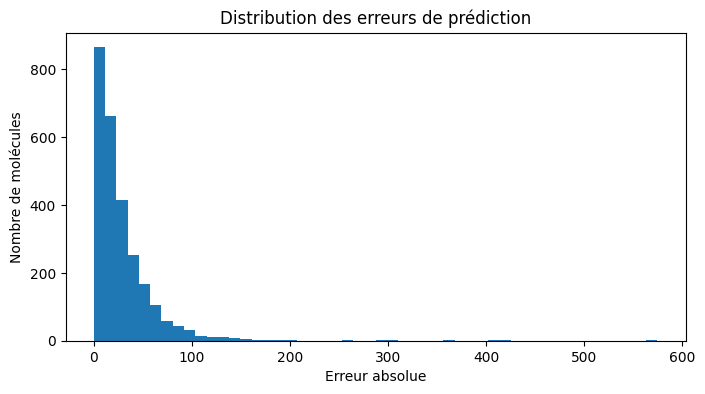

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_errors["error"], bins=50)
plt.xlabel("Erreur absolue")
plt.ylabel("Nombre de molécules")
plt.title("Distribution des erreurs de prédiction")
plt.show()


In [23]:
# Top 10 molécules avec plus grosse erreur
worst_cases = df_errors.sort_values("error", ascending=False).head(10)
print("Top 10 erreurs :")
display(worst_cases[["ID", "SMILES", "target", "prediction", "error"]])

# Top 10 meilleures
best_cases = df_errors.sort_values("error", ascending=True).head(10)
print("Top 10 prédictions les plus précises :")
display(best_cases[["ID", "SMILES", "target", "prediction", "error"]])


Top 10 erreurs :


KeyError: "['ID', 'SMILES', 'target'] not in index"

In [ ]:
correlations = df_errors.corr(numeric_only=True)["error"].sort_values(ascending=False)
print(correlations.head(20))


In [ ]:
import seaborn as sns

sns.scatterplot(x="MolWt", y="error", data=df_errors)
plt.title("Erreur vs Masse molaire")

sns.scatterplot(x="TPSA", y="error", data=df_errors)
plt.title("Erreur vs Surface polaire (TPSA)")

sns.scatterplot(x="NumHDonors", y="error", data=df_errors)
plt.title("Erreur vs Donneurs de H")


In [ ]:
df_errors["MolWt_bin"] = pd.cut(df_errors["MolWt"], bins=5)
mae_by_bin = df_errors.groupby("MolWt_bin")["error"].mean()
print(mae_by_bin)

plt.figure(figsize=(8,4))
mae_by_bin.plot(kind="bar")
plt.title("Erreur moyenne selon la masse molaire")
plt.ylabel("MAE")
plt.show()


In [22]:
#Test de modèle sur données de test
X_test = X_test_df
predictions = model.predict(X_test)
print(predictions)

[349.4662158  312.83332135 216.1021169  206.27906606 232.67738685
 338.03836631 241.80663511 314.30054964 283.30852252 274.70478722
 258.59073666 300.99518637 301.40381987 257.99700141 264.14597589
 611.73114123 288.31196722 277.62715708 394.73919717 154.09961906
 141.99979202 145.15220906 401.6271818  210.39502858 301.17947737
 190.76829706 625.37048146 472.37570883 415.22557724 326.69043676
 380.40741219 260.91755266 280.60780904 176.48255119 325.65396776
 287.95911857 313.20780224 283.70344286 231.76649658 322.20512711
 222.57766036 290.82289124 202.87999032 147.64295883 209.81126139
 336.28606081 335.1315924  269.99766585 286.35025519 348.25956408
 327.32329645 340.26774068 118.01173355 310.6473456  280.70442016
 296.43105997 462.72187611 251.59357037 321.03160641 236.76018642
 319.37625605 320.68623413 194.88707125 283.87782636 388.03492622
 169.89271594 265.30910901 324.06041357 239.43549235 317.55495482
 307.43544453 378.92748279 197.40106346 204.33355802 191.83364894
 292.37061

In [ ]:
group_cols = [c for c in df_errors.columns if "group_" in c]
group_mae = {}
for col in group_cols:
    mae = df_errors.groupby(pd.cut(df_errors[col], bins=3))["error"].mean().mean()
    group_mae[col] = mae
sorted_group_mae = sorted(group_mae.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top groupes avec plus forte erreur moyenne :")
for g, e in sorted_group_mae:
    print(f"{g}: {e:.2f}")


In [ ]:
#Export au format csv
id = test_data_set['id']
Tm = predictions
dict = {"id": id, "Tm": Tm}
submission_df = pd.DataFrame(dict)

# Sauvegarder le DataFrame en fichier CSV
output_csv_path = "submission.csv"
submission_df.to_csv(output_csv_path, index=False, sep=',')

print(f"Fichier CSV généré : {output_csv_path}")
print(submission_df)

In [ ]:
from IPython.display import FileLink
FileLink("submission.csv")